### Common imports

In [186]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import scipy
import scipy.ndimage
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from imageio import imread, imsave
import cv2

## Problem 1

Because it is given that the ball is made of specular material, we can assume equality of angle of incidence and reflection. Please refer to the diagram below, where I have shown the 3 vectors L, R and N. I will first solve the problem solve using general vector notation, i.e.

$N$ = unit normal along the direction connecting the sphere center to the specular highlight

$R$ = camera "look" vector, given to be $[0,0,1]$

$L$ = unit vector along direction of light source

Clearly, the vector connecting the tip of $L$ to that of $R$, is bisected by $N$, giving rise to 2 equal blue vectors. The blue vector is obtained by subtracting the projection of $R$ on $N$, from $R$, i.e. $R - (N.R)N$. This means that $L$ is simply twice the blue vector subtracted from $R$, i.e. $R - 2(R - (N.R)N)$ $= 2(N.R)N - R$.

We now plug in the values from the given information. $R$ is given to be $[0,0,1]$, while $N$ can be obtained by combining the facts that it goes from the center of sphere to the specular highlight, and that the specular highlight lies on the sphere, giving us $\left[x_s-x_c,\ y_s-y_c,\ \sqrt{r^2 - (x_s-x_c)^2 - (y_s-y_c)^2}\right]$. We still need to normalize the vector, hence we get

$$
\begin{align*}
    N\ &=\ \left[\frac{x_s-x_c}{r},\ \frac{y_s-y_c}{r},\ \sqrt{1 - \left(\frac{x_s-x_c}{r}\right)^2 - \left(\frac{y_s-y_c}{r}\right)^2}\right]\\\\
    \therefore\quad L\ &=\ \begin{bmatrix}
2\frac{x_s-x_c}{r}\sqrt{1 - \left(\frac{x_s-x_c}{r}\right)^2 - \left(\frac{y_s-y_c}{r}\right)^2}\\
2\frac{y_s-y_c}{r}\sqrt{1 - \left(\frac{x_s-x_c}{r}\right)^2 - \left(\frac{y_s-y_c}{r}\right)^2}\\
1-2\left( \left(\frac{x_s-x_c}{r}\right)^2 + \left(\frac{y_s-y_c}{r}\right)^2\right)
\end{bmatrix}
\end{align*}
$$

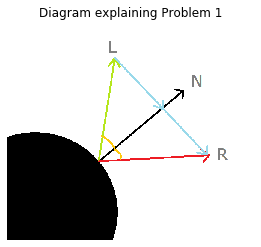

In [333]:
plt.axis('off')
plt.title('Diagram explaining Problem 1')
plt.imshow(np.asarray(Image.open('diagram.png')))
plt.show()

# Photometric Stereo

The following are the helper functions that were already defined in the starter notebook, and were used by me for a variety of tasks in this part.

In [176]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

def plot_normal_map(normal_map):
    normal_viz = normal_map[:, ::, :]

    normal_viz = normal_viz + np.equal(np.sum(normal_viz, 2, 
    keepdims=True), 0.).astype(np.float32)*np.min(normal_viz)

    normal_viz = (normal_viz - np.min(normal_viz))/2.
    plt.axis('off')
    plt.title('Normal Map')
    plt.imshow(normal_viz)
    plt.show()

In [169]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

#### Plot the albedo and the surface norms. 

In [189]:
def plot_albedo_and_surface_normals(albedo_image, surface_normals):
    """
    albedo_image: h x w matrix
    surface_normals: h x w x 3 matrix.
    """
    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
    ax = axes[0]
    ax.axis('off')
    ax.set_title('albedo')
    ax.imshow(albedo_image, cmap='gray')

    ax = axes[1]
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0], cmap='jet')
    ax = axes[2]
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1], cmap='jet')
    ax = axes[3]
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2], cmap='jet')

    fig.colorbar(im, ax=axes, fraction=0.02, aspect=15)
    plt.show()

#### Plot the height map

In [29]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

def display_3d(albedo_image, height_map, elev=20, azim=20):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(elev, azim)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

---
### Your implementation

The following are the codes that I wrote myself, as per as the requirements of Problems 2, 3, 4 and 5.

In [165]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    
    processed_imarray = imarray - np.dstack([ambimage]*imarray.shape[2])
    processed_imarray = np.clip(processed_imarray, 0, None)/255.0
    return processed_imarray

In [162]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    
    albedo_image = np.empty(imarray.shape[0:2])
    surface_norms = np.empty([imarray.shape[0], imarray.shape[1], 3])
    
    for px in range(imarray.shape[1]):
        for py in range(imarray.shape[0]):
            normal_times_albedo = np.linalg.lstsq(light_dirs, imarray[py,px,:], rcond=None)[0]
            albedo_image[py, px] = np.linalg.norm(normal_times_albedo)
            surface_norms[py, px, :] = normal_times_albedo/albedo_image[py, px]
            
    return albedo_image, surface_norms

In [167]:
def get_surface(surface_normals):
    """
    Inputs:
        surface_normals:h x w x 3
    Outputs:
        height_map: h x w
    """
    height_map1 = np.zeros(surface_normals.shape[0:2])
    height_map2 = np.zeros(surface_normals.shape[0:2])
    
    for py in range(surface_normals.shape[0]):
        for px in range(surface_normals.shape[1]):
            height_map1[py, px] = np.sum(surface_normals[0,:px,0]/surface_normals[0,:px,2])\
                                    + np.sum(surface_normals[:py,px,1]/surface_normals[:py,px,2])
            
    for px in range(surface_normals.shape[1]):
        for py in range(surface_normals.shape[0]):
            height_map2[py, px] = np.sum(surface_normals[py,:px,0]/surface_normals[py,:px,2])\
                                    + np.sum(surface_normals[:py,0,1]/surface_normals[:py,0,2])
    
    height_map = (height_map1 + height_map2)/2.0
    return height_map

## Main functions

The following are the results and observations for Problems 2 to 6, using my implementations of the functions `preprocess`, `photometric_sterio`, and `get_surface`, defined above.

### Problems 2, 3, 4, 5

First, I have read all the images and light source directions. I am plotting 9 images (including an ambient image) from the subject name `yaleB02`.

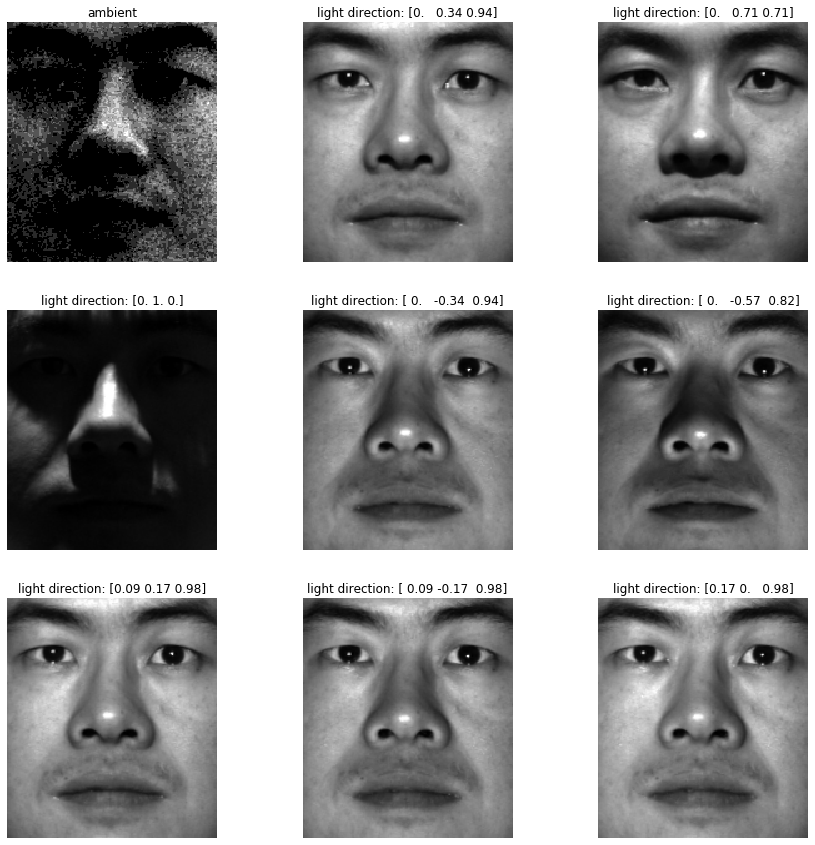

In [182]:
root_path = 'data/croppedyale/'
subject_names = ['yaleB01', 'yaleB02', 'yaleB05', 'yaleB07']

integration_method = 'average'
save_flag = False

full_path = '%s%s' % (root_path, subject_names[1])
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_names[1], 64)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, coords in enumerate(np.vstack([np.repeat([0,1,2], 3), np.tile([0,1,2], 3)]).T):
    ax = axes[coords[0], coords[1]]
    ax.axis('off')
    ax.set_title('ambient')
    
    if i == 0:
        ax.imshow(ambient_image, cmap='gray')
    else:
        ax.set_title('light direction: ' + str(np.round(light_dirs[i,:], 2)))
        ax.imshow(imarray[:,:,i], cmap='gray')

Qualitatively speaking, we can make some interesting observations about the shading cues in the above images. As expected, for every light direction, the parts of the face receiving more light is brighter, and the parts receiving less light are darker. This is significantly pronounced for the fourth image, where most of the light falls only on the straight part of the nose (which is very bright), while the rest of the face is almost completely dark due to lack of both direct as well as indirect light. Another interesting thing I can observe is that since the nose has a spherical component in the images, we can see the specular highlight on the tip of the nose, in all but one of the images. The only image where it is not visible is the fourth image, where the light source is vertically above the subject, hence it is the straight part of the nose which reflects the most amount of light instead of the tip of the nose. The final noteworthy thing is the eyeballs. In almost all the images (where the eyeballs are visible), the specular highlight can be used to give us the direction of light if we make a few assumptions like the radius of the eyeball. 

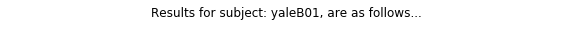

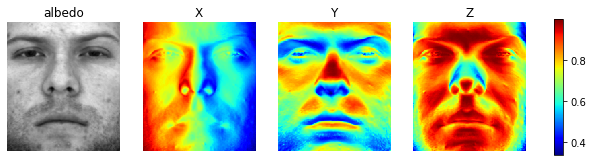

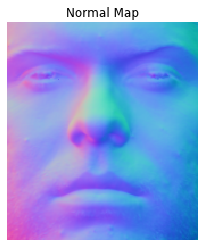

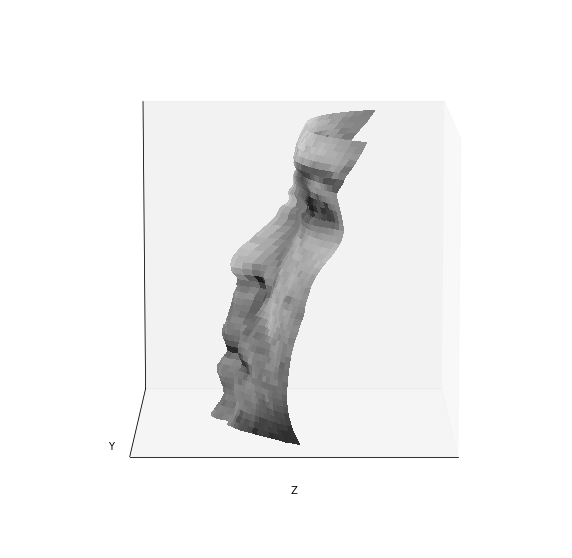

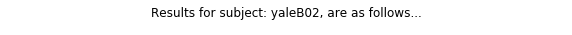

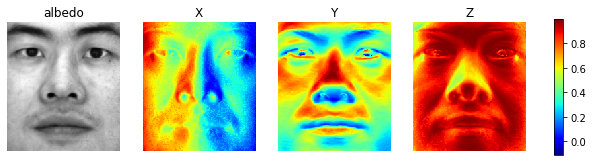

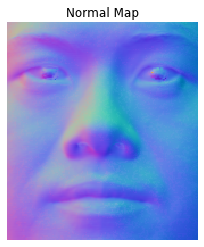

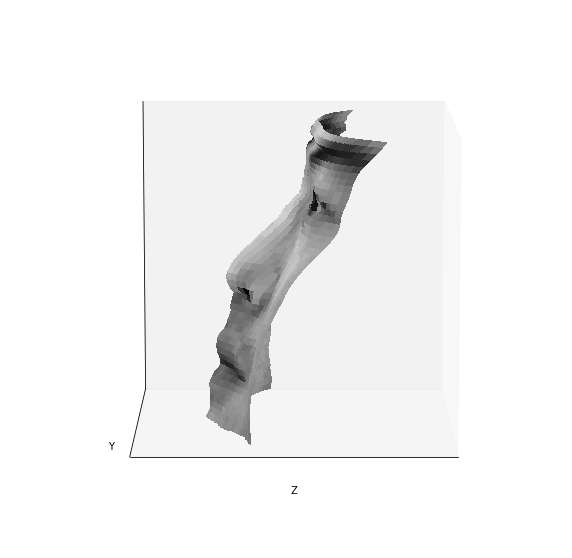

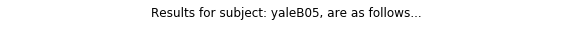

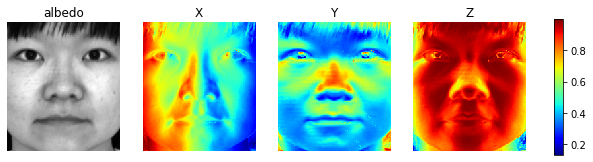

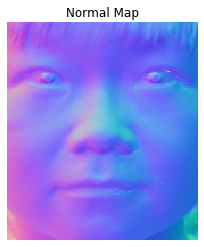

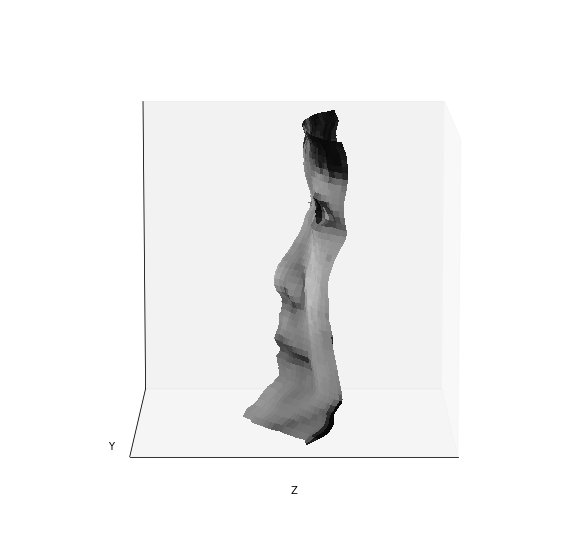

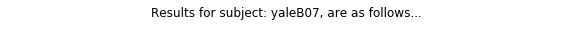

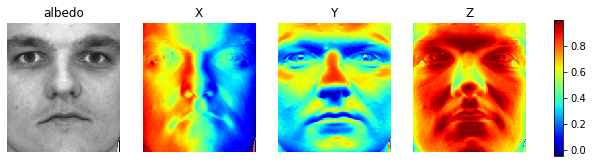

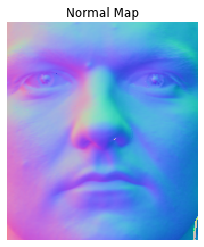

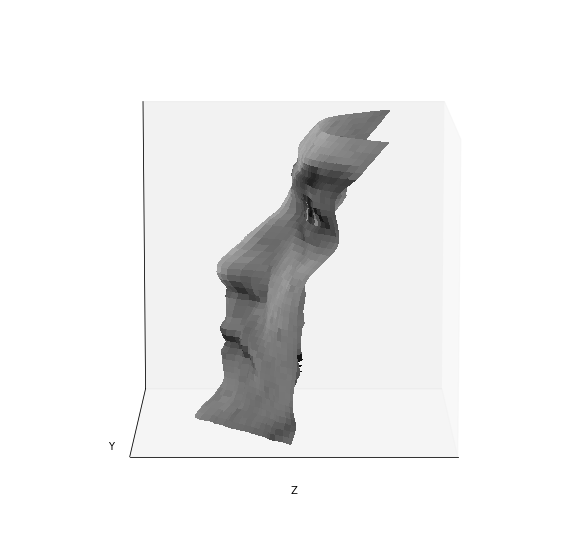

In [192]:
for subject_name in subject_names:
    full_path = '%s%s' % (root_path, subject_name)
    ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

    processed_imarray = preprocess(ambient_image, imarray)
    plt.figure(figsize = (10, 0.1))
    plt.axis('off')
    plt.title('Results for subject: ' + subject_name + ', are as follows...')

    albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)
    plot_albedo_and_surface_normals(albedo_image, surface_normals)
    plot_normal_map(surface_normals)
    height_map = get_surface(surface_normals)
    display_3d(albedo_image, height_map, elev=10, azim=90)

#if save_flag:
#    save_outputs(subject_name, albedo_image, surface_normals)

In the above part, I have given the results of Problems 3, 4 and 5, i.e. the preprocessing, albedo and surface normals, and the height maps for the 4 subjects. I gave all the answers together because it was easier running a `for` loop for the subjects. For the heightmap, I have taken the average of the heights obtained by integrating first along row then column, and then first along column then row.


## Problem 6

The first big assumption of photometric stereo that gets violated by this dataset is that these are Lambertian surfaces. We might be incorrectly assuming that diffuse reflection is taking place, when maybe the reflection is specular in nature. The second big assumption of photometric stereo that surely gets violated by this dataset is that of constant albedo. This can be understood by partitioning the 64 images (for a particular subject) into groups of 8. Calculating the albedo using these 8 different subsets, give us 8 different albedo images, which were different enough to refute the constant albedo assumption. That being said, while I could pinpoint the fact that constant albedo assumption was getting violated, I could not really figure out how to solve the issue (i.e. how to find a good subset of the images that can lead to a better reconstruction). I think a big problem is that it is bery challenging to qualitatively evaluate the height map obtained via these different subsets, and they seem to all look fairly decent.


# Denoising

Here, I shall try denoising the slater image and subsequently the chess image.

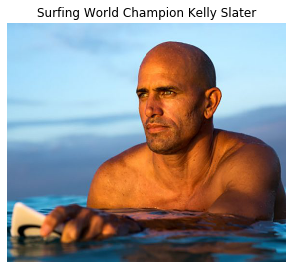

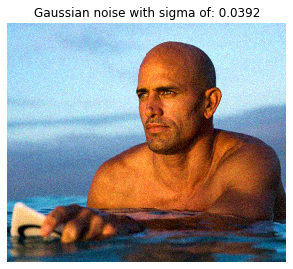

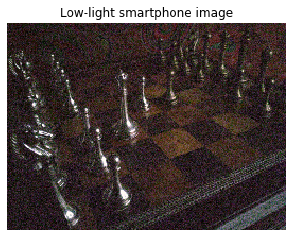

In [330]:
slater_image = imread('data/slater.jpg')/255.

# Note: we are reducing the size for faster processing.
slater_image = cv2.resize(slater_image, (280, 240))

sigma = 10/255.

plt.figure(figsize=(5,10))
plt.axis('off')
plt.imshow(slater_image, cmap = 'gray')

def noising_model(image, sigma):
    noise = np.random.normal(0, sigma, (image.shape))
    return image + noise

noisy_image = noising_model(slater_image, sigma=sigma)

# need to bring us better into range
noisy_image = np.clip(noisy_image, 0, 1)

plt.title("Surfing World Champion Kelly Slater")
plt.figure(figsize=(5,10))
plt.axis('off')
plt.title("Gaussian noise with sigma of: %.4f" % sigma)
plt.imshow(noisy_image)

# "real" noise image
chess_raw = imread("data/chess.png")

chess_noisy = cv2.resize(chess_raw, (int(chess_raw.shape[1]/4), int(chess_raw.shape[0]/4)))/255.
plt.figure(figsize=(5,10))
plt.axis('off')
plt.title("Low-light smartphone image")
plt.imshow(chess_noisy)

## Problems 7 and 8

Here, I first define the `median_filter` and `mean_filter`.

In [217]:
def median_filter(data, filter_size):    
    rdata = scipy.ndimage.median_filter(data[:,:,0], size = filter_size)
    gdata = scipy.ndimage.median_filter(data[:,:,1], size = filter_size)
    bdata = scipy.ndimage.median_filter(data[:,:,2], size = filter_size)
    
    return np.dstack([rdata, gdata, bdata])
        
def mean_filter(data, filter_size):
    kernel = np.ones((filter_size, filter_size))/(filter_size**2)
    
    rdata = cv2.filter2D(data[:,:,0], -1, kernel)
    gdata = cv2.filter2D(data[:,:,1], -1, kernel)
    bdata = cv2.filter2D(data[:,:,2], -1, kernel)
    
    return np.dstack([rdata, gdata, bdata]).clip(0., 1.)

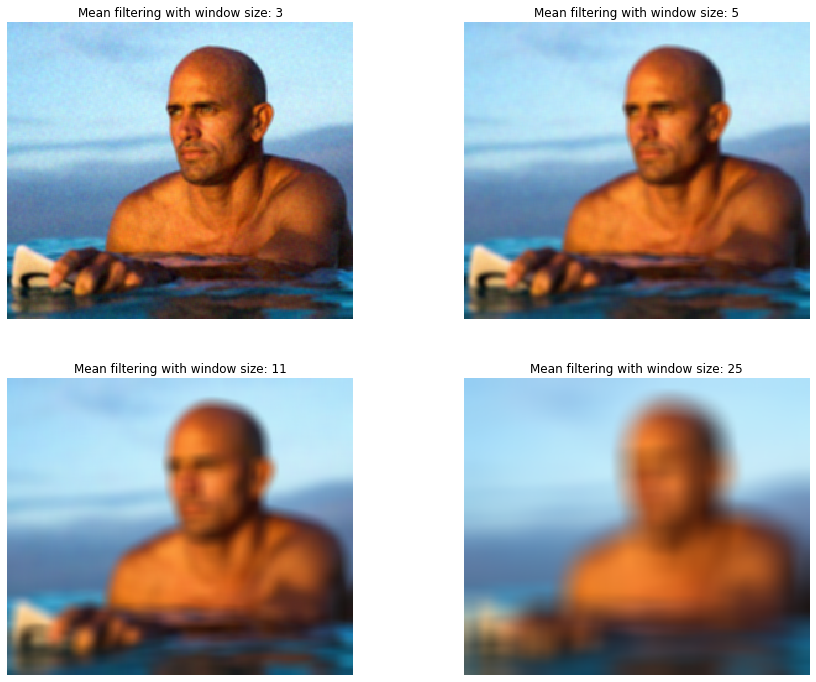

In [229]:
window_sizes = [3, 5, 11, 25]

mean_filtered_images = [mean_filter(noisy_image, window_size) for window_size in window_sizes]
median_filtered_images = [median_filter(noisy_image, window_size) for window_size in window_sizes]

# Mean filtering using various window sizes

plt.figure(figsize=(15,12))
plt.subplot(221)
plt.axis('off')
plt.title("Mean filtering with window size: {}".format(window_sizes[0]))
plt.imshow(mean_filtered_images[0])
plt.subplot(222)
plt.axis('off')
plt.title("Mean filtering with window size: {}".format(window_sizes[1]))
plt.imshow(mean_filtered_images[1])
plt.subplot(223)
plt.axis('off')
plt.title("Mean filtering with window size: {}".format(window_sizes[2]))
plt.imshow(mean_filtered_images[2])
plt.subplot(224)
plt.axis('off')
plt.title("Mean filtering with window size: {}".format(window_sizes[3]))
plt.imshow(mean_filtered_images[3])
plt.show()

Mean filtered images have been plotted above using window sizes $[3,5,11,25]$. However, none of the window sizes do a good job. Smaller window sizes seem to preserve detail well, but does not get rid of the noise much, while the larger filters gets rid of the noise but blurs the image heavily. It seems that a window size of $5$ gives the best tradeoff of getting rid of the noise, and preserving detail, though it is still not great.

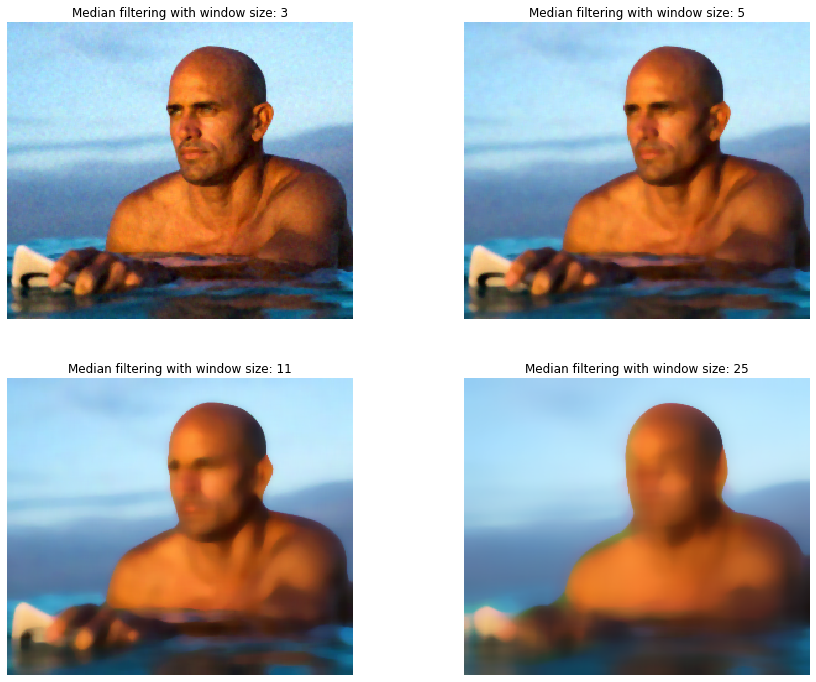

In [230]:
# Median filtering using various window sizes

plt.figure(figsize=(15,12))
plt.subplot(221)
plt.axis('off')
plt.title("Median filtering with window size: {}".format(window_sizes[0]))
plt.imshow(median_filtered_images[0])
plt.subplot(222)
plt.axis('off')
plt.title("Median filtering with window size: {}".format(window_sizes[1]))
plt.imshow(median_filtered_images[1])
plt.subplot(223)
plt.axis('off')
plt.title("Median filtering with window size: {}".format(window_sizes[2]))
plt.imshow(median_filtered_images[2])
plt.subplot(224)
plt.axis('off')
plt.title("Median filtering with window size: {}".format(window_sizes[3]))
plt.imshow(median_filtered_images[3])
plt.show()

Median filtered images have been plotted above using window sizes $[3,5,11,25]$. Here also, smaller window sizes seem to preserve detail well, but does not get rid of the noise much, while the larger filters gets rid of the noise but blurs the image heavily (though the nature of blurring is a bit different in comparison to the mean filter). It seems that a window size of $5$ gives the best tradeoff of getting rid of the noise, and preserving detail, and is pretty decent. Overall, I feel median filter is superior to mean filter as it incorporates the pixel intensity changes a bit more judiciously.

## Problem 9

Now, I am going to define the comparison methods like `mse` and `psnr`, and use it to evaluate the quality of denoising algorithms.

In [341]:
def psnr(original_image, new_image):
    return 20*np.log10(1.0/np.sqrt(mse(original_image, new_image)))

def mse(original_image, new_image):
    return np.mean((original_image - new_image)**2)

In [348]:
print('MSE for noisy image: %.5f\n' % mse(slater_image, noisy_image))

for i in range(4):
    print("MSE for mean filtered image with window size = %d, is: %.5f" %\
                  (window_sizes[i], mse(slater_image, mean_filtered_images[i])))
    print("MSE for median filtered image with window size = %d, is: %.5f" %\
                  (window_sizes[i], mse(slater_image, median_filtered_images[i])))
          
print('\n')

print("PSNR for noisy image: %.3f\n" % psnr(slater_image, noisy_image))
          
for i in range(4):
    print("PSNR for mean filtered image with window size = %d, is: %.5f" %\
                  (window_sizes[i], psnr(slater_image, mean_filtered_images[i])))
    print("PSNR for median filtered image with window size = %d, is: %.5f" %\
                  (window_sizes[i], psnr(slater_image, median_filtered_images[i])))

MSE for noisy image: 0.00145

MSE for mean filtered image with window size = 3, is: 0.00060
MSE for median filtered image with window size = 3, is: 0.00052
MSE for mean filtered image with window size = 5, is: 0.00115
MSE for median filtered image with window size = 5, is: 0.00068
MSE for mean filtered image with window size = 11, is: 0.00349
MSE for median filtered image with window size = 11, is: 0.00208
MSE for mean filtered image with window size = 25, is: 0.00895
MSE for median filtered image with window size = 25, is: 0.00672


PSNR for noisy image: 28.376

PSNR for mean filtered image with window size = 3, is: 32.24508
PSNR for median filtered image with window size = 3, is: 32.85841
PSNR for mean filtered image with window size = 5, is: 29.38870
PSNR for median filtered image with window size = 5, is: 31.65920
PSNR for mean filtered image with window size = 11, is: 24.56967
PSNR for median filtered image with window size = 11, is: 26.82427
PSNR for mean filtered image with wind

From the values above, it seems that the MSE for both mean and median filters get larger as the window size increases, suggesting that the denoising gets worse. However, in both mean and median filters, to the naked eye, it seems pretty clear that window size of 5 does the best job, even better than 3. Thus the MSE comparison method is not very accurate, since it cannot seperately handle the tradeoff between noise removal and blurring. However, the MSE values do agree with the fact that the median filter consistently outperforms the mean filter.

The PNSR says the same story. Since higher the PNSR, the better the reconstructed image, hence we see that the median filter again keeps outperforming the mean filter of the same window size. Here also, the PNSR keeping decreasing with the window size, which does not match with the evaluation by my eyes, since the denoised image obtained by window size 5 is the best in my opinion. Clearly, neither MSE nor PNSR are foolproof methods of evaluating denoised images, and the human eye definitely seems to have the last say in the matter.


## Problem 10

Now we define the bilateral means filter.

In [311]:
def compute_weight(colors, col_sigma=10/255.):
    return np.exp(-((colors[0] - colors[1])**2)/(2*col_sigma**2))
    
def bilateral_filter(image, col_sigma=10/255., window=21):
    denoised = np.zeros_like(image)
    
    for i in range(3):
        noisy = image[:,:,i]
        
        for py in range(image.shape[0]):
            for px in range(image.shape[1]):
                intensities = np.zeros((window, window))
                weights = np.zeros((window, window))
                
                start_y, stop_y = int(py-(window-1)/2), int(py+(window-1)/2)
                start_x, stop_x = int(px-(window-1)/2), int(px+(window-1)/2)
                
                for window_y in np.linspace(start_y, stop_y, num = window, dtype = int):
                    for window_x in np.linspace(start_x, stop_x, num = window, dtype = int):
                        if (window_y >= 0 and window_y < image.shape[0]) and (window_x >= 0 and window_x < image.shape[1]):
                            colors = np.array([noisy[py, px], noisy[window_y, window_x]])
                            intensities[window_y - start_y, window_x - start_x] = noisy[window_y, window_x]
                            weights[window_y - start_y, window_x - start_x] = compute_weight(colors, col_sigma)
                            
                denoised[py, px, i] = np.sum(intensities*weights)/np.sum(weights)
    
    return denoised

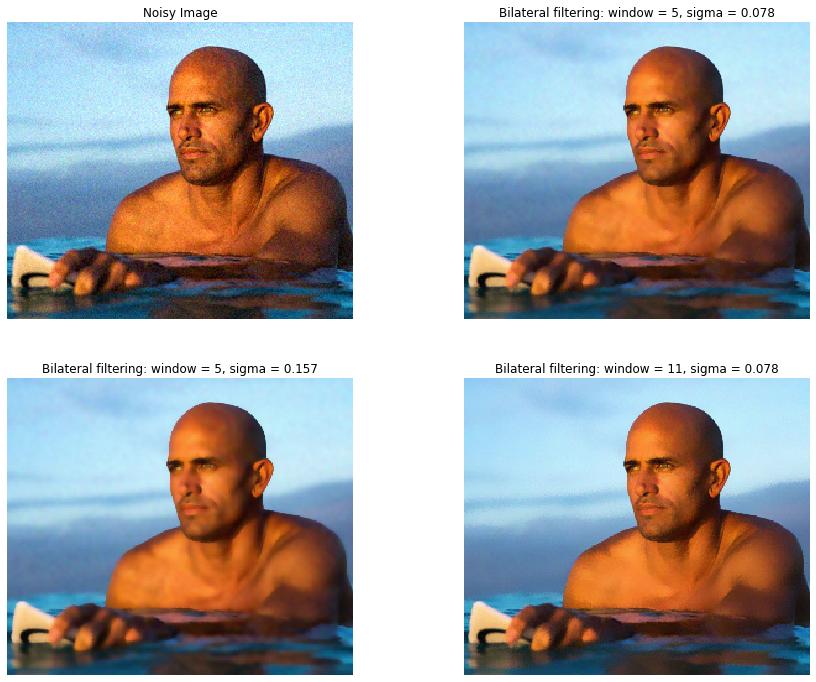

PSNR for bilateral filtered image with window = 5, sigma = 20/255, is equal to: 34.275
PSNR for bilateral filtered image with window = 5, sigma = 40/255, is equal to: 33.809
PSNR for bilateral filtered image with window = 11, sigma = 20/255, is equal to: 32.961


In [312]:
bilateral_filtered_images = []
bilateral_filtered_images.append(bilateral_filter(noisy_image, col_sigma=20/255., window=5))
bilateral_filtered_images.append(bilateral_filter(noisy_image, col_sigma=40/255., window=5))
bilateral_filtered_images.append(bilateral_filter(noisy_image, col_sigma=20/255., window=11))

plt.figure(figsize=(15,12))
plt.subplot(221)
plt.axis('off')
plt.title("Noisy Image")
plt.imshow(noisy_image)
plt.subplot(222)
plt.axis('off')
plt.title("Bilateral filtering: window = %d, sigma = %.3f" % (5, 20/255.))
plt.imshow(bilateral_filtered_images[0])
plt.subplot(223)
plt.axis('off')
plt.title("Bilateral filtering: window = %d, sigma = %.3f" % (5, 40/255.))
plt.imshow(bilateral_filtered_images[1])
plt.subplot(224)
plt.axis('off')
plt.title("Bilateral filtering: window = %d, sigma = %.3f" % (11, 20/255.))
plt.imshow(bilateral_filtered_images[2])
plt.show()

print("PSNR for bilateral filtered image with window = 5, sigma = 20/255, is equal to: %.3f"\
          % psnr(slater_image, bilateral_filtered_images[0]))
print("PSNR for bilateral filtered image with window = 5, sigma = 40/255, is equal to: %.3f"\
          % psnr(slater_image, bilateral_filtered_images[1]))
print("PSNR for bilateral filtered image with window = 11, sigma = 20/255, is equal to: %.3f"\
          % psnr(slater_image, bilateral_filtered_images[2]))

To my eye, it seems that window = 11, and $\sigma = 20/255$ is doing the best job, and in my opinion it has given the nest denoised image among all the considered methods in this entire problem set. That being said, the PNSR values tell a different story. According to them, a window size of 5, and $\sigma = 20/255$ has the highest PNSR. I do not agree with that, because the reconstructed image using window = 11, and $\sigma = 20/255$, clearly does a far superior job at preserving details, and at the same time removes the noise pretty decently.


## Problem 11

Now we define the nonlocal means filter, which I have implemented pixelwise. The downside is that is takes ages to run.

In [351]:
def compute_nlm_weight(intensities, patch_size = 3, sigma = 20/255.):
    window = intensities.shape[0]
    distance = 0
    start_ref, stop_ref = int((window-1)/2) - int((patch_size-1)/2), int((window-1)/2) + int((patch_size-1)/2)
    
    for py in np.linspace(int((patch_size-1)/2), window-int((patch_size-1)/2), num = window-patch_size+1, dtype = int):
        for px in np.linspace(int((patch_size-1)/2), window-int((patch_size-1)/2), num = window-patch_size+1, dtype = int):
            start_y, stop_y = py - int((patch_size-1)/2), py + int((patch_size-1)/2)
            start_x, stop_x = px - int((patch_size-1)/2), px + int((patch_size-1)/2)
            
            distance += np.linalg.norm(intensities[start_y:stop_y, start_x:stop_x, :] -\
                                    intensities[start_ref:stop_ref, start_ref:stop_ref, :])**2 
    
    return np.exp(-distance/(2 * (patch_size)**2 * sigma**2))

def nlm_filter(image, window = 5, patch_size = 3, sigma = 20/255.):
    denoised = np.zeros_like(image)
        
    for py in range(image.shape[0]):
        for px in range(image.shape[1]):
            intensities = np.zeros((window, window, 3))
            weights = np.zeros((window, window))
                
            start_y, stop_y = int(py-(window-1)/2), int(py+(window-1)/2)
            start_x, stop_x = int(px-(window-1)/2), int(px+(window-1)/2)
                
            for window_y in np.linspace(start_y, stop_y, num = window, dtype = int):
                for window_x in np.linspace(start_x, stop_x, num = window, dtype = int):
                    if (window_y >= 0 and window_y < image.shape[0]) and (window_x >= 0 and window_x < image.shape[1]):
                        intensities[window_y - start_y, window_x - start_x, :] = image[window_y, window_x, :]
                        
            for window_y in np.linspace(start_y, stop_y, num = window, dtype = int):
                for window_x in np.linspace(start_x, stop_x, num = window, dtype = int):
                    if (window_y >= 0 and window_y < image.shape[0]) and (window_x >= 0 and window_x < image.shape[1]):
                        weights[window_y-start_y, window_x-start_x] = compute_nlm_weight(intensities, patch_size, sigma)
                            
            denoised[py, px, 0] = np.sum(intensities[:,:,0]*weights)/np.sum(weights)
            denoised[py, px, 1] = np.sum(intensities[:,:,1]*weights)/np.sum(weights)
            denoised[py, px, 2] = np.sum(intensities[:,:,2]*weights)/np.sum(weights)
    
    return denoised

PSNR for nonlocal means filtered image with window = 15, patch size = 5, sigma = 20/255, is equal to: 29.379


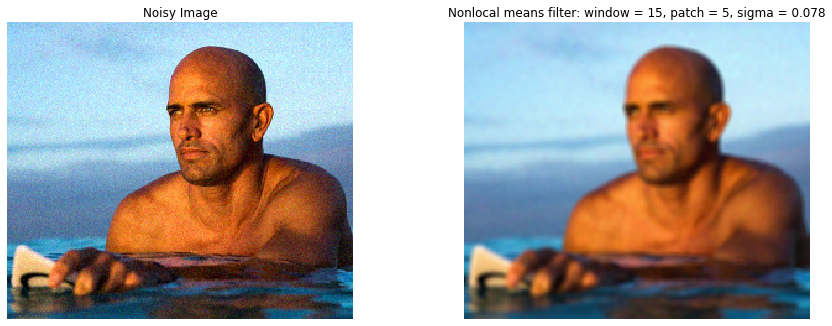

In [350]:
nlm_filtered_image = nlm_filter(noisy_image, window = 15, patch_size = 5, sigma = 20/255.)

plt.figure(figsize=(15,12))
plt.subplot(221)
plt.axis('off')
plt.title("Noisy Image")
plt.imshow(noisy_image)
plt.subplot(222)
plt.axis('off')
plt.title("Nonlocal means filter: window = %d, patch = %d, sigma = %.3f" % (15, 5, 20/255.))
plt.imshow(nlm_filtered_image)

print("PSNR for nonlocal means filtered image with window = 15, patch size = 5, sigma = 20/255, is equal to: %.3f"\
          % psnr(slater_image, nlm_filtered_image))

I have run the nonlocal mean filtering for only one choice of $(window\_size,\ \sigma)$ tuple, because it takes a lot of time to run. It seems that non-local means does not do a great job of preserving detail really. At least to my eyes, it seems like it does a similar job as the median filter. The bilateral filter seems to be doing the best job among all the methods that I have considered. Qualitatively speaking, the PNSR is also not much better than the the noisy image, and hence is roughly on par with the best median filter that we have considered.


## Chess Image Denoising

Now I run denoising algorithms for the chess image with unknown noise. I have used mean and median filters (both with window sizes of 3), plus bilateral filter using three different values of $\sigma$.

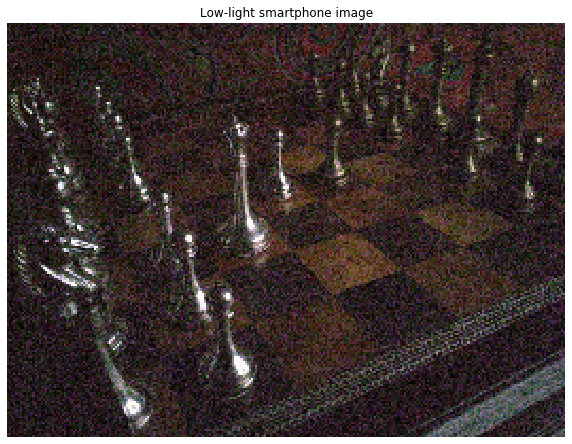

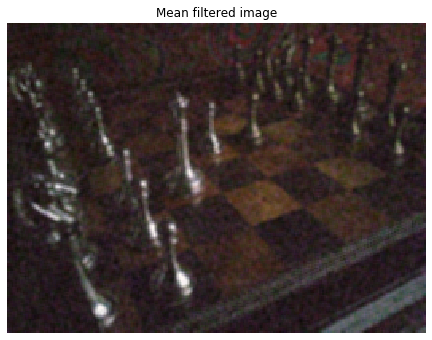

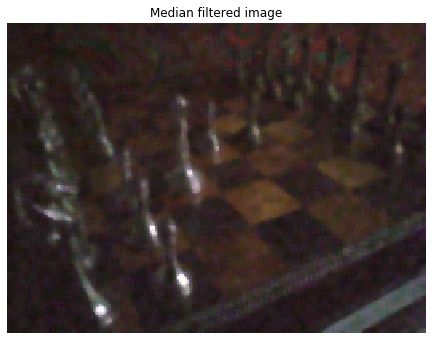

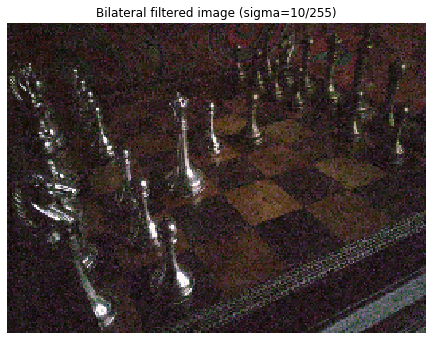

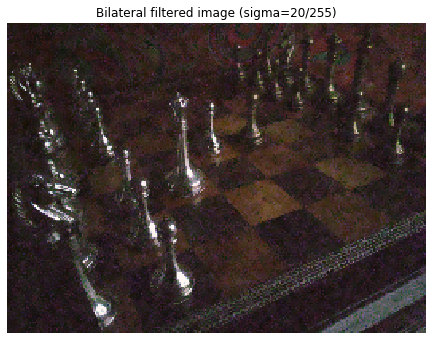

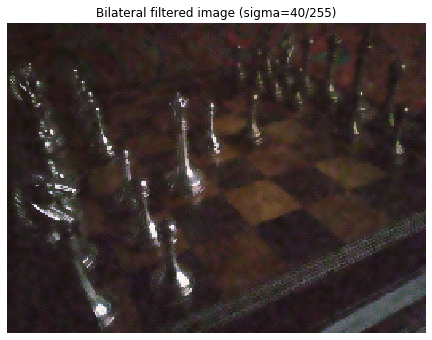

In [353]:
chess_raw = imread("data/chess.png")

chess_noisy = cv2.resize(chess_raw, (int(chess_raw.shape[1]/4), int(chess_raw.shape[0]/4)))/255.
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Low-light smartphone image")
plt.imshow(chess_noisy)

mean_filtered_chess = mean_filter(chess_noisy, 3)
median_filtered_chess = median_filter(chess_noisy, 5)
bilateral_filtered_chess_10 = bilateral_filter(chess_noisy, window = 5, col_sigma=10/255.)
bilateral_filtered_chess_20 = bilateral_filter(chess_noisy, window = 5, col_sigma=20/255.)
bilateral_filtered_chess_40 = bilateral_filter(chess_noisy, window = 5, col_sigma=40/255.)

plt.figure(figsize=(7.5,15))
plt.axis('off')
plt.title("Mean filtered image")
plt.imshow(mean_filtered_chess)

plt.figure(figsize=(7.5,15))
plt.axis('off')
plt.title("Median filtered image")
plt.imshow(median_filtered_chess)

plt.figure(figsize=(7.5,15))
plt.axis('off')
plt.title("Bilateral filtered image (sigma=10/255)")
plt.imshow(bilateral_filtered_chess_10)

plt.figure(figsize=(7.5,15))
plt.axis('off')
plt.title("Bilateral filtered image (sigma=20/255)")
plt.imshow(bilateral_filtered_chess_20)

plt.figure(figsize=(7.5,15))
plt.axis('off')
plt.title("Bilateral filtered image (sigma=40/255)")
plt.imshow(bilateral_filtered_chess_40)

The window size for each of the above bilateral filtered images is taken to be $5$, since it looks like a reasonable size. I have not tried using nonlocal means filtering on this chess image since it was taking a lot of time. Anyway, it seems that a window of size $5$ and $\sigma = 20/255$ seems to give us the best denoised image as per the naked eye. 